1. 데이타 준비 : LightningDataModule
1. 모델 설계 : LightningModule
1. 학습 설계 : Trainer
1. 학습 수행 및 평가 

### 1. 데이터 준비 : LightningDataModule
* 기능 : Load a dataset from the Hugging Face Hub, or a local dataset.
* 구조
    * init : 변수 초기화
        * 데이터 저장 디렉토리 초기화
        * 배치 사이즈 초기화
        * 학습 및 테스트 데이터 세 사이즈 초기화
        * train, valid, test 용 데이터셋 변수 선언
        * train/valid 용 이미지 데이터 변환 함수 목록 초기회
    * prepare_data : 데이터 다운로드 (한 번만 실행)
        * 신규 환경에서 한번만 실행
        * 데이터 다운로드 용도
    * setup : 데이터셋 분할 및 설정
        * 'fit' stage일 때는 train용, valid용 데이터셋 생성
        * 'test' stage일 때는 test용 데이테셋 생성
        * stage가 명시되지 않으면 모든 데이터셋 생성
    * train_dataloader : 학습용 데이터 로더 반환
    * val_dataloader : 학습 진행 검증용 데이터 로더 반환
    * test_dataloader : 테스트용 데이터 로더 반환
* CIFAR-10 데이터 셋 
    * 32 x 32 x 3, 
    * 10개 class, 
    * 50_000개 train (클래스당 5_000개)
    * 10,000개 test (클래스당 1,000개)


In [19]:
import lightning as L
from datasets import Dataset, DatasetDict, load_dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from typing import Optional, Tuple
import torch
from PIL import Image
from typing import override
import logging

# CUDA Tensor Core 최적화 설정
torch.set_float32_matmul_precision('medium')  # 'high' for maximum speed, 'medium' for balance


In [ ]:
class CIFAR10DataModule(L.LightningDataModule):
    def __init__(
        self,
        data_dir: str = "./data",
        img_size: int = 32,
        batch_size: int = 256,
        num_workers: int = 0, # in jupyter 0
        val_split: float = 0.2,
        train_size: int = 50_000,
        test_size: int = 10_000,
        seed: int = 42
    ):
        super().__init__()
        pass

    def prepare_data(self) -> None:
        """데이터 다운로드 (한 번만 실행)"""
        pass

    def setup(self, stage: Optional[str] = None) -> None:
        """데이터셋 분할 및 설정"""
        pass

    def _train_collate_fn(self, batch):
        """훈련용 배치 처리 함수"""
        pass

    def _val_collate_fn(self, batch):
        """검증/테스트용 배치 처리 함수"""
        pass

    def train_dataloader(self) -> DataLoader:
        pass

    def val_dataloader(self) -> DataLoader:
        pass

    def test_dataloader(self) -> DataLoader:
        pass


#### 2. 모델 설계 : LightningModule
* 기능 : Neural Network 구조를 설계한다.
     * 학습 후 최대한 라벨과 유사하게 예측할 수 있어야 한다.(라벨과 동일한 답을 얻는 것이 목표, valid accuracy 97% 이상)
     * 적은 시간으로 학습을 완료 할 수 있디(파라미터 숫자가 적을 것, 간단한 계산식)
     * 메모리가 적은 환경에서도 학습 및 활용 할 수 있다( 파라미터 갯수 적을 것)
     * 학습한 파라미터를 시각적으로 확인해 볼 수 있다.
     * 학습중인 결과를 중간에 저장할 수 있고, 저장한 파라미터를 로딩하여 추가학습을 진행할 수 있다.( checkpoint, freeze )
     * 검증결과 무의미한 학습은 목표 epoch 만큼 학습을 진행하기 전이라도 점출 수 있다.
     * 학습 진행 과정 혹은 결과를 그래프로 모니터링 할 수 있다.
     * CUDA를 쉽게 활용할 수 있다.
* 구조
    * Initialization (__init__ and setup()).
    * Train Loop (training_step())
    * Validation Loop (validation_step())
    * Test Loop (test_step())
    * Prediction Loop (predict_step())
    * Optimizers and LR Schedulers (configure_optimizers())

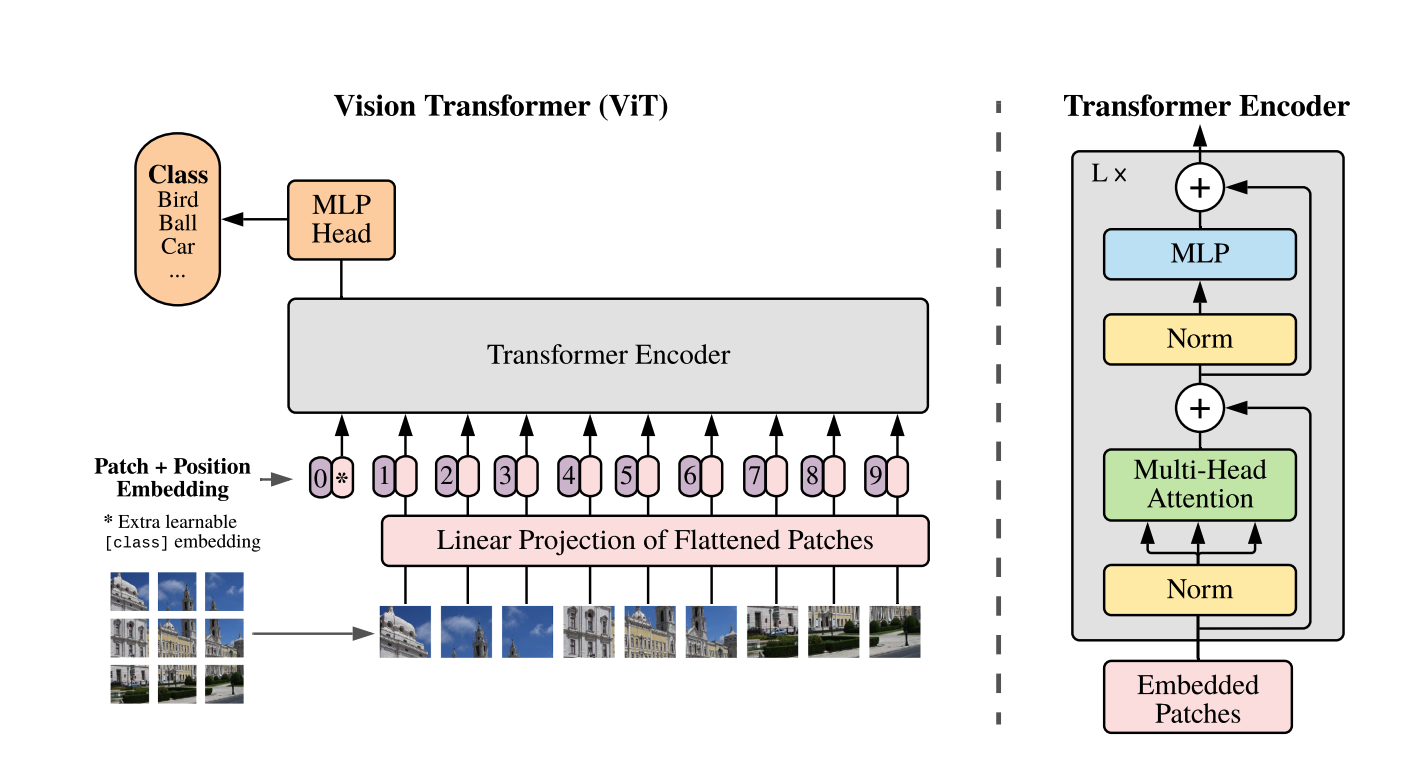

In [3]:
from IPython.display import Image
# ViT 구조
Image('./Vit.png')

#### Position Embedding 에 필요한 SinusoidalPositionalEncoding class
* ViT 논문에서는 임의의 수로 positional embedding vector를 생성했음
* 어떤 방식이 좋은지 계속 연구중임
* 여러가지 방식
    * positional embedding vector를 사용하지 않는 방법 ( 위치 정보가 불필요한 문제에서는 가능 할 듯 )
    * 학습대상으로 사용하는 방법 ( ViT 논문 방식 )
        * positional embedding vector를 임의로 생성
        * 학습 대상으로 삼아 매 batch 학습 후 update 함
        * 다음 batch 학습 때는 이전 update된 positional embedding vector를 사용함 
    * 학습하지 않고 고정값을 사용 ( Transformer 논문 방식 )
        * positional embedding vector를 위치마다 다른 vector가 되도록 설계하여 생성
        * patch embedding 후 미리 생성된 positional embedding vector를 더하여 학습
        * positional embedding vector는 상수로 관리하고, 매 batch 마다 update하지 않음

In [ ]:
from typing import Any
import torch.nn as nn
import math

class SinusoidalPositionalEncoding(nn.Module):
    """Sinusoidal Positional Encoding 클래스 (Transformer 논문 방식)"""
    
    def __init__(self, seq_len, d_model):
        super().__init__()
        pass
    
    def _create_encoding(self):
        """Sinusoidal position encoding 생성"""
        pass
    
    def forward(self, batch_size=None):
        pass

#### patch embedding 와 position embedding 설계
* 주요 기능 및 특징
    * 입력 데이터인 이미지를 embedding vector로 변환
    * 변환하는 데 사용하는 convolution 도 학습 대상에 포함
    * 학습 대상에 포함시키기 위해 nn.Module 로 설계
* patch embedding
    * 기능 : 이미지를 패치로 나누고 각 패치를 임베딩 벡터로 변환
    * 약어 
        * B : Batch_size
        * H : Height
        * W : Width
        * embed_dim : Embedding Vector Dimention
        * P : Patch size ( P x P )
        * seq_len : sequence length = Token number = Patch number = H/P x W/P
    * input image[B, 3, H, W]
    * (2D convolution) -> embedding vector [B, embed_dim, H/P, W/P ], 각 패치마다 임의의 임베딩 벡터 생성
    * (flatten) -> 1-D vector [B, embed_dim, seq_len]
    * (transpose) -> [B, seq_len, embed_dim], 토큰별 embedding vector
* CLS embedding ( Extra learnable [class] embedding )
    * CLS token에 대한 embedding vector를 추가
    * (cls token 추가) -> [B, seq_len + 1, embed_dim], 
        * CLS 토큰의 embedding vector도 학습 대상
        * 모든 embedding vector는 학습 대상이 되는 것이 때문에 CLS 토큰도 자연스럽게 학습 대상
        * embedding vector space라는 다차원 공간에서 각 토큰의 위치를 결정하는게 학습이기 때문
    * CLS token이 꼭 필요할까?
        * 다른 token도 MHA에 의해 contextaulized 되기 때문에 불필요해 보임
        * 다른 token으로 class를 예측해도 accuracy가 같은지 확인 해 볼 것
* position embedding
    * 기능
        * 위치를 구분하기 위한 임베딩 벡터 생성
        * patch embedding vector에 위치 embedding vector를 더하여 최종 embedding vector로 생성
    * 위치 임베딩 벡터 종류        
        * 랜덤 넘버로 생성하는 방법 : 모델에 포함, 학습 대상 ( Parameter )
        * 위치별로 다른 벡터를 만들어서 상수로 사용하는 방법 : 모델에 포함, 학습 대상 아님 ( Buffer )
        * 위치 벡터를 사용하지 않음 : 특별히 위치가 중요 정보가 아닐 때 사용해도 될 듯

In [ ]:
class PatchEmbedding(nn.Module):
    """이미지를 패치로 분할하고 임베딩 벡터로 변환하는 클래스"""

    def __init__(self, img_size=32, patch_size=4, in_channels=3, embed_dim=64):
        super().__init__()
        pass
    
    # 이미지 [B, C, H, W] -> 토큰(임베딩 벡터) [B, num_patches, embed_dim]
    def forward(self, x):
        """
        Args:
            x: 입력 이미지 [B, C, H, W]
            
        Returns:
            패치 토큰들 [B, num_patches, embed_dim]
        """
        pass

class CLSEmbedding(nn.Module):
    """CLA token의 embedding vector를 생성하고 추가하는 class"""

    def __init__(self, embed_dim):
        super().__init__()
        pass
    
    def __repr__(self):
        pass
    
    def forward(self, x):
        """
        Args:
            x: 입력 토큰들 [B, num_patches, embed_dim]
            
        Returns:
            CLS embedding이 추가된 토큰들 [B, num_patches+1, embed_dim] = [B, seq_len, embed_dim]
        """
        pass

class PositionEmbedding(nn.Module):
    """Position embedding을 관리하는 클래스 (learned, sinusoidal, none 지원)"""
    
    def __init__(self, seq_len, embed_dim, embed_type='learned'):
        """
        Args:
            seq_len: 시퀀스 길이 (num_patches + 1, CLS token 포함)
            embed_dim: 임베딩 차원
            embed_type: 'learned', 'sinusoidal', 'none'
        """
        pass
    
    def __repr__(self):
        pass
    
    def forward(self, x):
        """
        Args:
            x: 입력 토큰들 [B, seq_len, embed_dim]
            
        Returns:
            position embedding이 추가된 토큰들 [B, seq_len, embed_dim]
        """
        pass

### Multi-Head Attention
* 목적 : 각 토큰들간의 관계를 파악하여 토큰의 임베딩 벡터가 context 정보를 포함하도록 학습

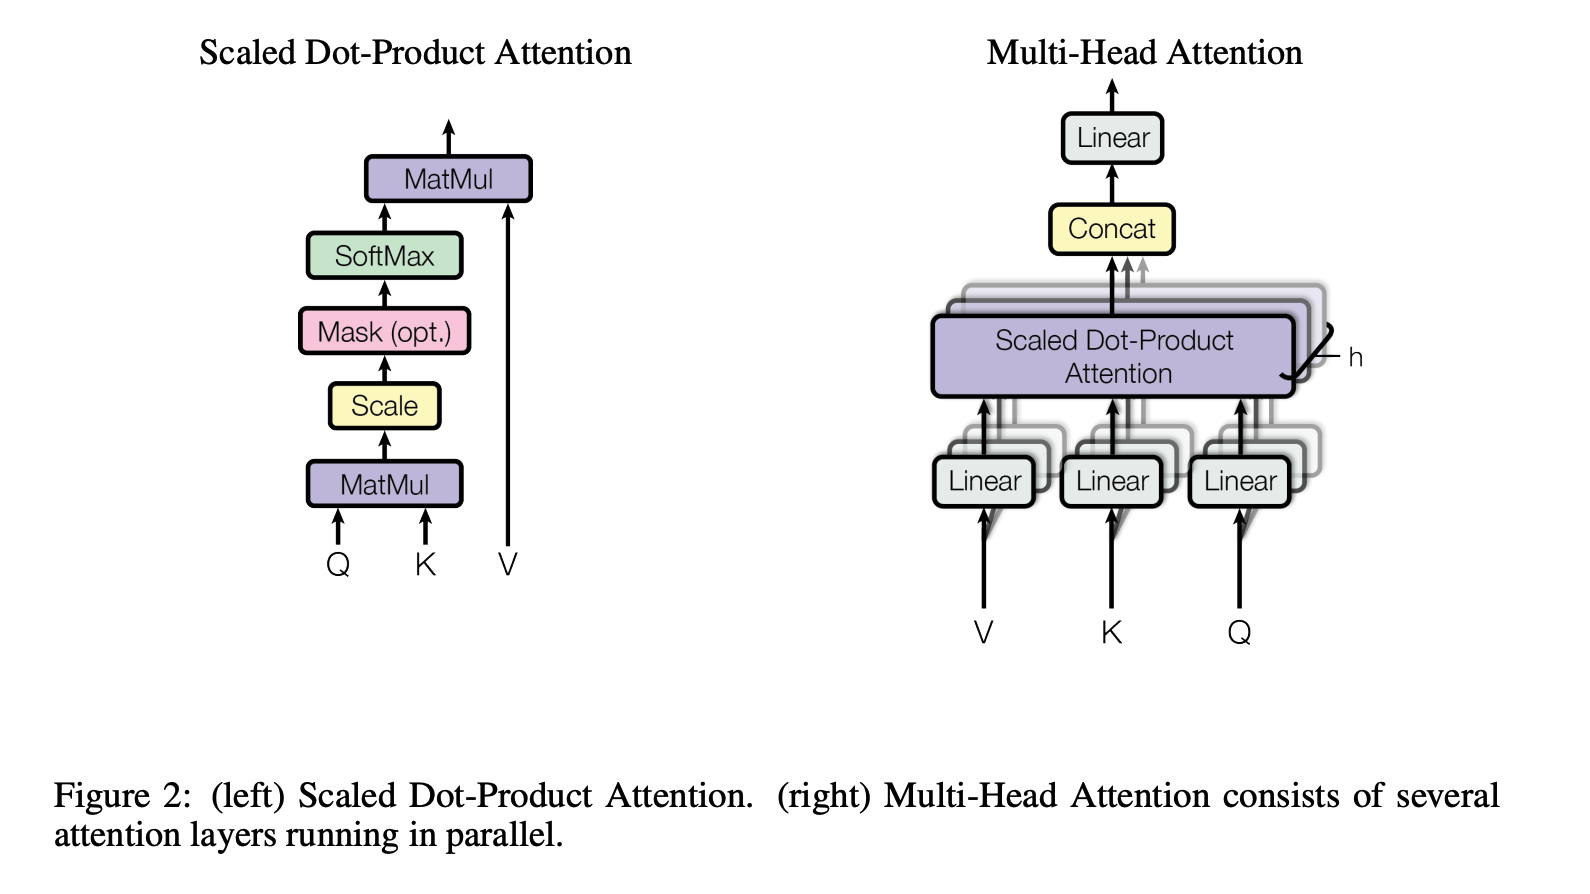

In [6]:
from IPython.display import Image
# MHA
Image('./MHA.png')

In [ ]:
class MultiHeadAttention(nn.Module):
    """Multi-Head Self-Attention 구현"""
    
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        pass
        
    def forward(self, x, return_attention=False):
        """
        Args:
            x: Input tensor [B, seq_len, embed_dim]
            return_attention: Whether to return attention weights
            
        Returns:
            output: [B, seq_len, embed_dim]
            attention_weights: [B, num_heads, seq_len, seq_len] (if return_attention=True)
        """
        pass

###  MLP block
* 목적
    * Attention으로 수집된 정보를 각 토큰별로 비선형 변환하여 더 풍부한 representation을 만듬
    * linear transformation의 조합인 MHA에 비선형성을 추가하여 다양한 모델의 패턴에 대응
* 기능
    * Feature Transformation : 각 토큰을 독립적으로 처리
    * 각 토큰 내부의 feature 를 변환
    * 임베딩 벡터를 4배 확장한 후 원래 demention으로 축소
        * 너무 크면 overfitting, 너무 작으면 underfitting
    * ViT에서는 ReLU 대신 GELU 사용
        * 더 부듯러운 비선형성 : x * 0.5 * (1 + tanh(sqrt(2/π) * (x + 0.044715 * x³)))
        * Gradient가 더 부드럽게 흐름
        * 음수 값도 완전히 0이 되지 않음
        * 더 나은 학습 안정성

### MLP Head
* 목적
    * CLS 토큰의 Transformer 출력으로 class를 예측하는 목적
    * feature space ( 아마도 embedding vector space ) 에서 class space로 변환
    * patch embedding이 image space에서 embedding vector space로 변환하는 것의 대칭점에 있음
* 전체 구조 측면에서 조명
    * ViT 전체 과정 : image 공간 -> embedding vector 공간 -> class 공간
    * 첫번째 변환은 patch embedding이 담당, 두번째 변환은 MLP Head가 담당

### MLP Block과 MLP Head의 차이

  | 구성 요소 | MLP Block                     | MLP Head               |
  |-------|-------------------------------|------------------------|
  | 위치    | Transformer 내부                | 모델 마지막                 |
  | 입력    | 모든 토큰 [B, seq_len, embed_dim] | CLS 토큰만 [B, embed_dim] |
  | 역할    | Feature transformation        | Classification         |
  | 잔차연결  | 있음 (x + mlp(x))               | 없음                     |
  | 정규화   | LayerNorm 적용                  | 적용 안함                  |

In [ ]:
class MLPBlock(nn.Module):
    def __init__(self, embed_dim, mlp_ratio=4.0, dropout=0.1):
        pass

    def forward(self, x):
        pass

In [ ]:
class MLPHead(nn.Module):
    def __init__(self, embed_dim, num_classes, hidden_dim=None):
        pass

    def forward(self, x):
        """
        Args :
            x: Any (include CLS) token representation [B, embed_dim]
        return :
            classification에 사용할 logits [B, num_classes]
        """
        pass

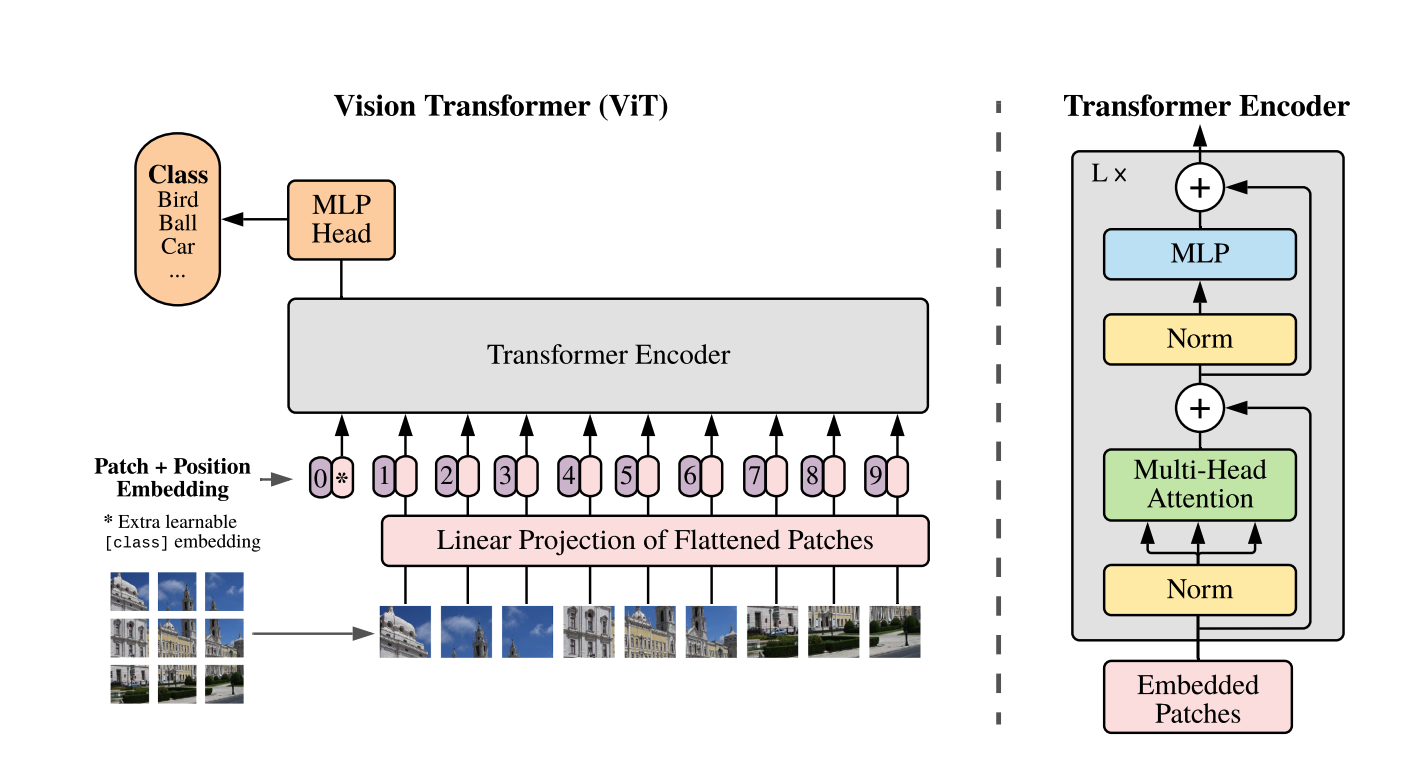

In [10]:
from IPython.display import Image
# ViT 구조
Image('./Vit.png')

#### Transformer Block
* 기능 
    * embedded patches 를 입력 받아 MHA로 contextualized 시킴
    * 각각 독립적인 개별 patch에 전체 이미지 정보를 가미함
    * 전체 이미지 관점에서 바라본 embedding vector로 변경
    * 거기에 MLPBlock로 각 패치별 특성을 학습한 결과를 반영
* embedding vector [B, seq_len, embed_dim] -> contextualized embedding vector [B, seq_len, embed_dim]
* CLS token은 임의로 설정한 값인데, 어떤 특성을 학습하게 되는 것일까?

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0):
        pass 

    def forward(self, x):
        pass

#### LightningModule로 구현한 ViT
* Patch Embedding
* CLS Embedding
* Position Embedding
* 

In [ ]:
from typing import Any
import torch.nn as nn
import math
import torch.nn.functional as F

class LightningTransformer(L.LightningModule):
    def __init__(self, 
                 img_size=32, 
                 patch_size=8, 
                 embed_dim=128, 
                 num_heads=4,
                 num_classes=10,
                 pos_embed_type='learned',  # 'learned', 'sinusoidal', 'none'
                 class_token_idx=0): # 0 = CLS token index
        pass

    # Raw logits를 리턴 : 에를 들면 softmax 적용 전
    def forward(self, x):
        """
        Args:
            x: 입력 이미지 [B, C, H, W]
            
        Returns:
            logits : classification에 활용할 raw data [B, num_classes]
        """
        pass

    def training_step(self, batch, batch_idx):
        pass
    
    def validation_step(self, batch, batch_idx):
        pass
    
    def test_step(self, batch, batch_idx):
        pass
    
    def predict_step(self, batch, batch_idx):
        pass
        
    # scheduler를 적용하도록 할 것
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(), 
            lr=1e-3,
            weight_decay=0.1
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer=optimizer,
            T_max=100
        )
        return [optimizer], [scheduler]

### 3. 학습 설계 : Trainer


In [ ]:
# Lightning Trainer 설정 및 학습
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger

class VerboseEarlyStopping(EarlyStopping):
    """더 자세한 로깅이 포함된 Early Stopping 콜백"""
    
    def on_validation_end(self, trainer, pl_module):
        pass
    
    def on_train_end(self, trainer, pl_module):
        pass
    
# Early Stopping 콜백 설정 (자세한 로깅 포함)
early_stopping = VerboseEarlyStopping(
    monitor='val_loss',  # 또는 'val_accuracy'
    patience=5,
    mode='min',  # val_loss의 경우 'min', val_accuracy의 경우 'max'
    verbose=True,
    strict=False,
    min_delta=0.001,  # 최소 개선 임계값
)

# 모델 체크포인트 콜백
checkpoint = ModelCheckpoint(
    monitor='val_loss',
    mode='min',
    save_top_k=3,
    filename='{epoch}-{val_loss:.4f}',
    save_last=True,
    #verbose=True
)

#callbacks = [checkpoint, early_stopping]
callbacks = [checkpoint]

In [14]:
# 데이터 모듈 생성
dm = CIFAR10DataModule(
    img_size=32,
    batch_size=256,
    train_size=10000,
    test_size=1000,
    val_split=0.1
)

# 데이터 준비 및 설정
#dm.prepare_data()
dm.setup('fit')

### 4. 학습 수행

In [18]:
# 학습용 모델 생성 (파라미터 수 줄여서 빠른 학습)
training_model = LightningTransformer(
    img_size=dm.img_size,
    patch_size=8,
    embed_dim=128,
    num_heads=4,
    class_token_idx=0
)

# 로거 설정
import datetime
version_name = datetime.datetime.now().strftime("%Y%m%d_%H%M")
logger = TensorBoardLogger(
    save_dir="./logs",
    name="myViT-128-0",
    version=version_name
    #version=None  # 자동으로 버전 생성
)

# Trainer 생성
trainer = L.Trainer(
    max_epochs=30,
    accelerator="auto",  # GPU가 있으면 자동으로 사용
    devices="auto",      # 사용 가능한 모든 디바이스 사용
    callbacks=callbacks,
    logger=logger,
    log_every_n_steps=5,
    val_check_interval=1.0,  # 매 epoch마다 validation 수행
    enable_progress_bar=True,
    enable_model_summary=True
)

print(f"\n=== 학습 시작 ===")
trainer.fit(training_model, dm)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..



=== 학습 시작 ===


/home/cho/workspace/boostcamp/.venv/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:751: Checkpoint directory ./logs/myViT-128-0/20250929_0908/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | patch_embed | PatchEmbedding    | 24.7 K | train
1 | cls_embed   | CLSEmbedding      | 128    | train
2 | pos_embed   | PositionEmbedding | 2.2 K  | train
3 | encoder     | Sequential        | 1.2 M  | train
4 | mlp_head    | MLPHead           | 1.3 K  | train
----------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.863     Total estimated model params size (MB)
79        Modules in train mode
0         Modules in eval mode


Epoch 29: 100%|██████████| 36/36 [00:09<00:00,  3.90it/s, v_num=0910, train_loss_step=1.470, train_loss_epoch=1.290]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 36/36 [00:09<00:00,  3.86it/s, v_num=0910, train_loss_step=1.470, train_loss_epoch=1.290]


### 5. CLS token vs 다른 토큰들의 classification 성능 비교 실험
* 결론은 어느 토큰으로 class를 예측하나 val_accuracy, val_loss 는 비슷하였음
* 데이터를 5만건 모두 학습하면 75% 정도 나오지만 시간이 오래 걸려 만건으로 줄여서 학습함
* ViT 논문에서는 Transformer Block이 12층으로 했지만, 과적합이 되서 6층으로 줄임
* class 식별용 token을 선택 한 후 학습함
    * class 학습과정에서 loss 계산과정에 class 예측용 토큰을 선택해야 하기 때문
    * token 선택이 loss 계산에 영향을 미치기 때문에 학습도 영향을 받을 것으로 판단하였음
* legends
    * myViT-128-0 : CLS 토큰으로 class 예측
    * myViT-128-1 : 첫번째 patch 토큰으로 class 예측
    * myViT-128-8 : 중간 patch 토큰으로 class 예측
    * myViT-128-16 : 마지막 patch 토큰으로 class 예측


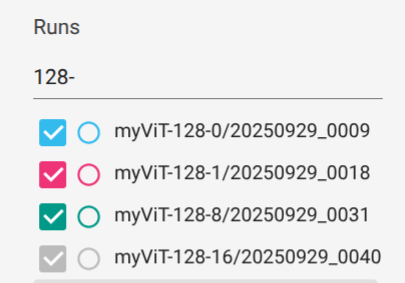

In [49]:
from IPython.display import Image
# legends
Image('./myvit_legend.png')

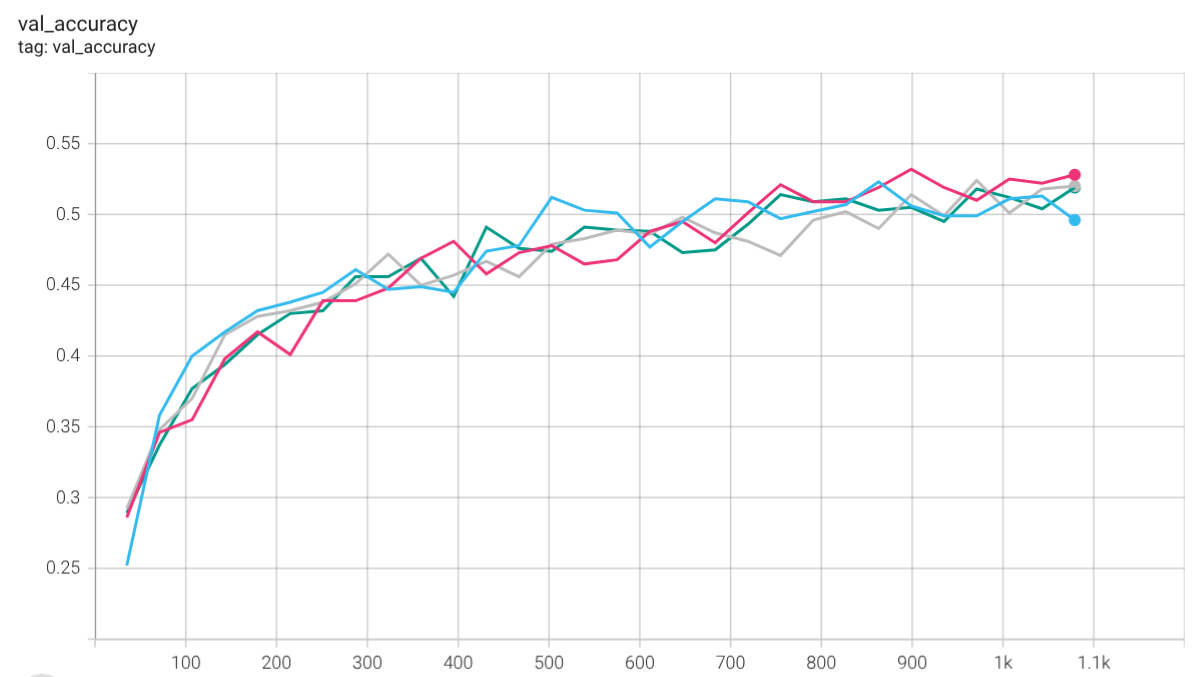

In [50]:
# val_accuracy
Image('./myvit_val_acc.png')

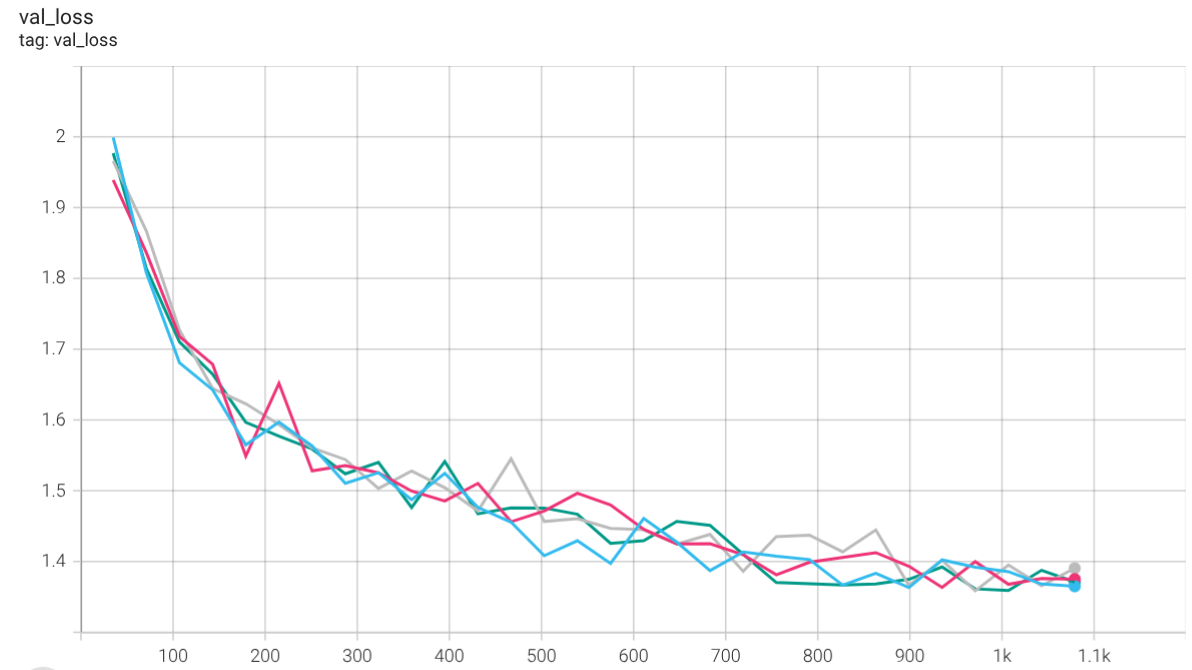

In [51]:
# val_loss
Image('./myvit_val_loss.png')